In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import drms
from astropy.coordinates import SkyCoord
import astropy.units as u 
import sunpy.coordinates
import astropy.io.fits as fits
import matplotlib.patches as ptc

Credit to Bobra for the photosphere code and for the AR bounding box code. That code can be found [here.](https://nbviewer.jupyter.org/github/mbobra/calculating-spaceweather-keywords/blob/master/feature_extraction.ipynb)

In [3]:
# Take in: t_rec
# Plot: full solar disk + ARs + network
time = "2011.02.14_15:00:00/10m"
c = drms.Client()


In [4]:
# keys, segments = c.query('hmi.sharp_720s[][{}]'.format(time), key='T_REC, URL,HARPNUM, LON_FWT, LAT_FWT', seg="magnetogram")
# print(keys)

seg_urls = c.query('hmi.sharp_720s[][{}]'.format(time), seg="magnetogram")
print(seg_urls.loc[1, "magnetogram"])

/SUM90/D1043168341/S00000/magnetogram.fits


/home/maxine/anaconda3/lib/python3.6/site-packages/drms/client.py:1100: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_seg = pd.DataFrame.from_items(zip(names, values))


In [5]:
def calculate_distance_graph(series):
    # get all indices that match, get skycoord objects
    skycoord_list = []
    count=series.shape[0]
    # Error because this line only returns 1 row.
    for ind in range(count):
        row = series.loc[series.index[ind]]
        hgs = SkyCoord(row["LON_FWT"]*u.deg,
                              row["LAT_FWT"]*u.deg,
                              obstime = row["T_REC"],
                              frame = "heliographic_stonyhurst")
        hc = hgs.transform_to("heliocentric")

        skycoord_list.append(hc)
    dist_graph = dict()
    # Initialize dict
    for i in range(count):
        dist_graph[i] = np.zeros(count)

    for i in range(count):
        for j in range(i, series.shape[0]):
            if i==j:
                dist_graph[i][j] = float('inf')
                dist_graph[j][i] = float('inf')
            else:
                # Calculate the Great-Circle distance
                dist = skycoord_list[i].separation(skycoord_list[j])
                dist_graph[i][j] = dist.degree
                dist_graph[j][i] = dist.degree

    # print(skycoord_list)
    return dist_graph, skycoord_list


In [8]:
keys_hmi, segments = c.query('hmi.M_720s[{}]'.format(time), key=drms.const.all, seg='magnetogram')
url_hmi = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_full_image = fits.getdata(url_hmi)                   # download the image data
header = dict(keys_hmi.iloc[0])
# Add a DATE-OBS keyword which seems to be required by sunpy.map.Map.
header['DATE-OBS'] = keys_hmi.DATE__OBS[0]

# Add HGLN_OBS keyword to avoid a warning in sunpy.map.Map.
header['HGLN_OBS'] = 0.0

/home/maxine/anaconda3/lib/python3.6/site-packages/drms/client.py:1089: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res_key = pd.DataFrame.from_items(zip(names, values))


In [9]:
keys_ccd, segments = c.query('hmi.sharp_720s[][{}]'.format(time), key=drms.const.all, seg='magnetogram')


In [10]:
dist_graph, skycoord_list = calculate_distance_graph(keys_ccd)


In [14]:
def get_mean_dist(dist_graph):
    sum = 0
    counter = 0
    graph = dist_graph.copy()
    for key in graph.keys():
        distances = np.delete(graph[key],key)

        for d in distances[key:]:
            if d != 0:
                sum += d
                counter += 1
        # if len(distances) != 0:
        #     sum += np.sum(distances)
    return sum / counter

In [15]:
def plot_dist_graph(dist_graph, x_middle, y_middle, thresh):
    
    for k in dist_graph.keys():
        # For each key ind > k_index, draw a line between x_middle[key], y_middle[key] and x_middle[ind], y_middle[ind]
        for i in range(k, len(dist_graph[k])):
            if dist_graph[k][i] < thresh:
                plt.plot([x_middle[k],x_middle[i]], [y_middle[k], y_middle[i]], linewidth=2, color='skyblue')


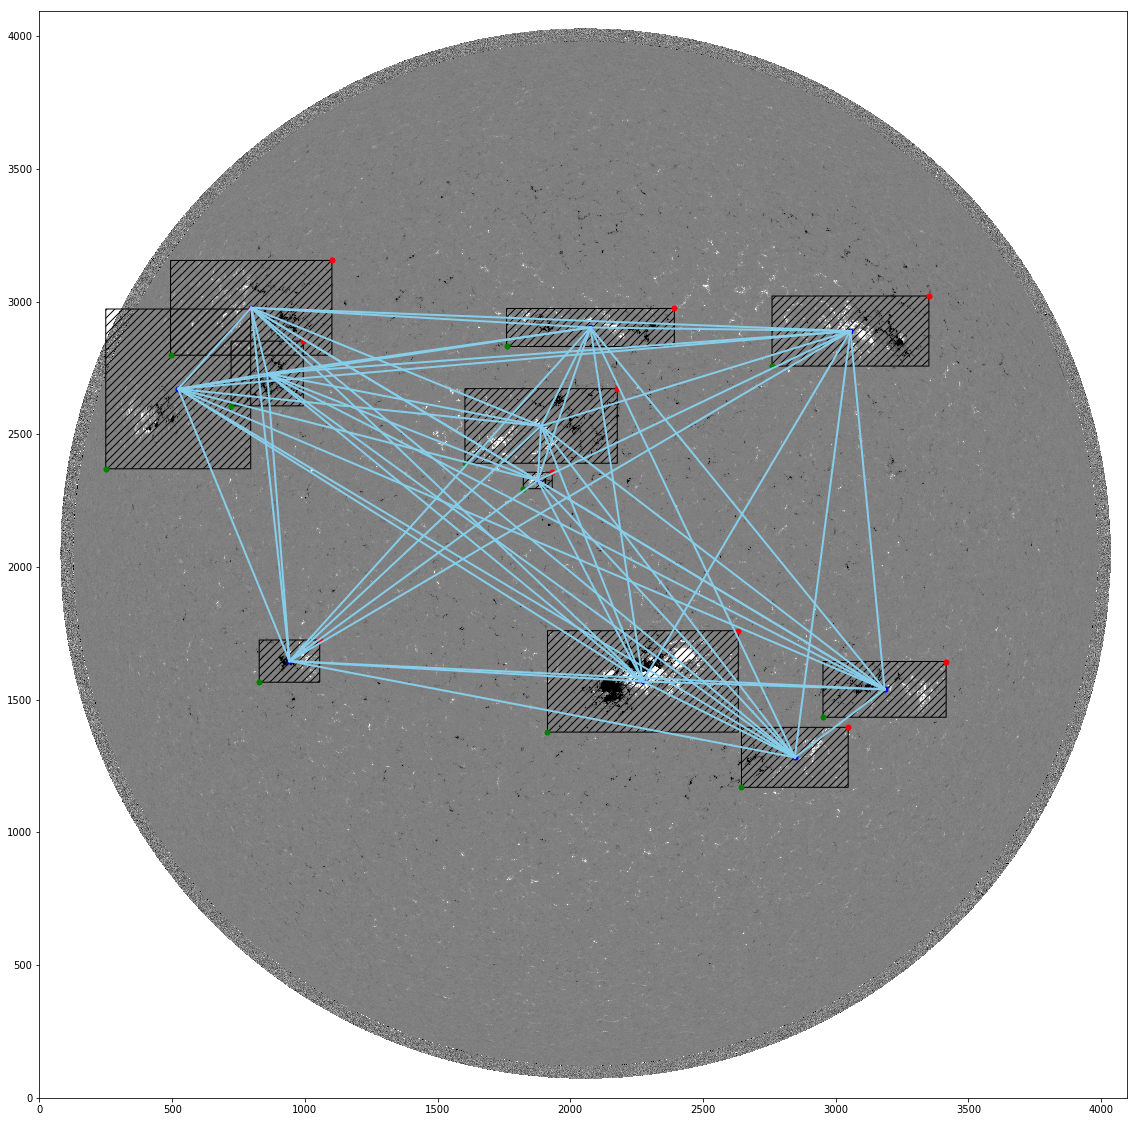

In [19]:
hmimag = plt.get_cmap('gray')
fig, ax = plt.subplots(1,1)

fig.set_size_inches(20,20)
x_middle = []
y_middle = []

for i, url_seg in enumerate(segments.loc[:,"magnetogram"]):
    url_ccd = 'http://jsoc.stanford.edu' + url_seg   # add the jsoc.stanford.edu suffix to the segment name
    photosphere_image = fits.open(url_ccd)                           # download the data
    XDIM_CCD = photosphere_image[1].data.shape[1]
    YDIM_CCD = photosphere_image[1].data.shape[0]
    
    if (keys_ccd.CROTA2[i] > 5.0):
#         print("The HMI camera rotation angle is",keys_ccd.CROTA2[i],". Rotating HMI images.")
        photosphere_full_image = np.rot90(photosphere_full_image,2)
        photosphere_image[1].data = np.rot90(photosphere_image[1].data,2)

    
    y1 = (2048. + keys_ccd.CRPIX2[i] - YDIM_CCD)  
    y2 = (2048. + keys_ccd.CRPIX2[i])
    x1 = (2048. + keys_ccd.CRPIX1[i] - XDIM_CCD)
    x2 = (2048. + keys_ccd.CRPIX1[i])


    # draw a box using matplotlib.patches.Rectangle
    ax.add_patch(ptc.Rectangle((x1, y1), XDIM_CCD, YDIM_CCD, hatch='///', fill=False, snap=False))
    
    # plot a green dot at the lower left-hand corner
    plt.plot(x1, y1, 'g.', markersize=10.0)

    # plot a red dot at the upper right-hand corner
    plt.plot(x2, y2, 'r.', markersize=10.0)

    plt.plot((x1+x2)/2, (y1+y2)/2, 'b.',markersize=10)

    x_middle.append((x1+x2)/2)
    y_middle.append((y1+y2)/2)
    
thresh = get_mean_dist(dist_graph)
plot_dist_graph(dist_graph, x_middle, y_middle, float('inf'))
plt.imshow(photosphere_full_image,cmap=hmimag,origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])


In [28]:
print(keys_ccd.LON_FWT)

0     36.320671
1     38.758030
2     28.806580
3      2.694037
4     -6.222026
5      6.878287
6    -36.926369
7    -39.875847
8    -40.521225
9    -59.132347
10    -5.086699
Name: LON_FWT, dtype: float64


The HMI camera rotation angle is 180.082581 . Rotating HMI images.


In [37]:
print(keys_ccd.CRPIX2)

0    1012.585205
Name: CRPIX2, dtype: float64
